# Almost-Linear RNNs Tutorial

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torch
import torch.nn as nn
from torch.nn.init import uniform_
import torch.nn.functional as F
from torch import optim

from dataset import TimeSeriesDataset
from linear_region_functions import *
import linear_region_functions as lrf

from matplotlib.colors import Normalize
from collections import Counter
import seaborn as sns

## AL-RNN Architecture

In [112]:
class AL_RNN(nn.Module):
    def __init__(self, M, P, N):
        super(AL_RNN, self).__init__()

        # Initialize model dimensions
        self.M = M
        self.P = P
        self.N = N   

        # Initialize model parameters A, W, h, B    
        self.A, self.W, self.h = self.initialize_AWh_random()
        self.B = self.init_uniform((self.N,self.M))
        
    def forward(self, z):
        # Make a copy of the input tensor to retain unactivated values
        z_unactivated=torch.clone(z)

        # Apply ReLU activation on the last P units
        z[:, -self.P:] = F.relu(z[:, -self.P:])

        # Compute the forward pass
        return self.A * z_unactivated + z @ self.W.t() + self.h
    
    
    def initialize_AWh_random(self):
        #Randomly initialize A, W, h
        A = nn.Parameter(torch.diagonal(self.normalized_positive_definite(self.M),0)) # Create diagonal matrix A from normalized positive definite matrix
        W = nn.Parameter(torch.randn(self.M, self.M)*0.01) # Initialize weight matrix W with gaussian random numbers
        h = nn.Parameter(torch.zeros(self.M)) # Initialize bias vector h to zero
        return A, W, h
    
    
    def normalized_positive_definite(self,M):
        # Generate a normalized positive definite matrix
        R = np.random.randn(M, M).astype(np.float32)
        K = np.matmul(R.T, R) / M + np.eye(M)  # R'R ./ M + I
        eigenvalues = np.linalg.eigvals(K)
        lambda_max = np.max(np.abs(eigenvalues))
        return torch.tensor(K / lambda_max).float()
    
    
    def init_uniform(self, shape):
        # Initialize a tensor with a uniform distribution within range [-1/sqrt(M), 1/sqrt(M)]
        tensor = torch.empty(*shape)
        r = 1 / math.sqrt(shape[0])
        torch.nn.init.uniform_(tensor, -r, r)
        return nn.Parameter(tensor, requires_grad=True)


@torch.no_grad() # Disables gradient calculation to save memory and computation
def predict_free_sequence(model, x, T):
    # Predicts a sequence without updating model parameters
    b, N = x.size()

    Z = torch.empty(size=(T, b, model.M), device=x.device) # Initialize output tensor for the predicted sequence
    z = x @ model.B # Initialize first latent state

    # Predict sequence by passing previous state through the model
    for t in range(0, T):
        z = model(z)  
        Z[t] = z    
    return Z.permute(1, 0, 2)

## Training routine

In [113]:
def predict_sequence_using_gtf(model, x, alpha, n_interleave):
    # Predicts a sequence using teacher forcing (only for training)
    x_ = x.permute(1, 0, 2) # Permute input to shape (sequence_length, batch_size, feature_dim)
    T, b, dx = x_.size() # T: sequence length, b: batch size, dx: feature dimension
    Z = torch.empty(size=(T, b, model.M), device=x.device)
    z =  x_[0] @ model.B # Initialize first latent state
    z = teacher_force(z, x_[0], alpha=1) # Apply teacher forcing to the initial state
    Z[0] = z

    # Generate sequence predictions
    for t in range(1, T):
        # Apply teacher forcing at regular intervals
        if (t % n_interleave == 0) and (t > 0):
            z = teacher_force(z, x_[t], alpha)
            
        # Update the latent state using the model
        z = model(z)
        Z[t] = z
    return Z.permute(1, 0, 2)

def teacher_force(z, x, alpha):
    # Teacher force the state z
    z[:, :N] = alpha * x + (1 - alpha) * z[:, :N]
    return z

def train_sh(model, dataset, optimizer, scheduler, loss_fn, num_epochs, alpha, n_interleave, batches_per_epoch=50):
    model.train() # Set model to training mode
    losses = []
    
    with trange(num_epochs, desc="Training Progress") as epochs:
        # Loop over batches in each epoch
        for _ in epochs:
            epoch_losses = []
            
            for _ in range(batches_per_epoch):
                optimizer.zero_grad() # Reset gradients for the optimizer
                
                x, y, s = dataset.sample_batch() # Sample a batch of data (x: inputs, y: targets)
                z_hat = predict_sequence_using_gtf(model, x, alpha, n_interleave) # Predict sequence using teacher forcing
                loss = loss_fn(z_hat[:,:,:model.N], y) # Calculate loss                        
                loss.backward() # Backward pass
                optimizer.step()
                epoch_losses.append(loss.item())
        

            scheduler.step() # Adjust learning rate based on the scheduler
            
            # Compute and store average loss for the epoch
            average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            epochs.set_postfix(loss=average_epoch_loss)
            losses.append(average_epoch_loss)

    return losses

## Load Data

In [114]:
X_train = np.load("lorenz63_train.npy").astype(np.float32)[500:]
X_test = np.load("lorenz63_test.npy").astype(np.float32)[500:]
T_train, N = X_train.shape
T_test = X_test.shape[0]

## Initialize Model

In [77]:
# number readout units
N=X_train.shape[-1]
#number of units in total
M=20
#number of piecewise linear units
P=2

model = AL_RNN(M=M, P=P, N=N)

## Training hyperparameters

In [78]:
batch_size = 16
sequence_length = 200
#teacher forcing alpha (GTF)
alpha=1
#teacher forcing interval (readout units are forced every time steps)
n_interleave=16

loss_fn = nn.MSELoss()
dataset = TimeSeriesDataset(X_train, sequence_length=sequence_length, batch_size=batch_size)

## Optimization

In [87]:
# optimization
num_epochs = 2000
learning_rate = 5e-3
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
# Setup scheduler
gamma = 10 ** (-3 / num_epochs)  # Compute gamma to decay from 10^-2 to 10^-5
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

## Training

In [8]:
losses = train_sh(model, dataset, optimizer, scheduler, loss_fn, num_epochs=num_epochs, alpha=alpha, n_interleave=n_interleave, batches_per_epoch=25)

Training Progress: 100%|██████████| 2000/2000 [40:15<00:00,  1.21s/it, loss=0.0169]


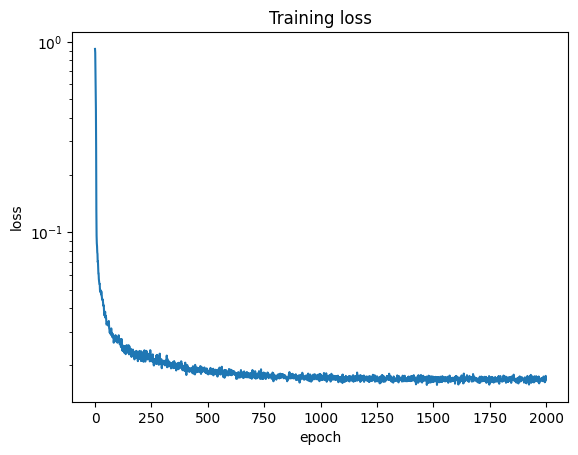

In [9]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")

## Saving/Loading

In [86]:
torch.save(model.state_dict(), "models/lorenz_m20_p2")

In [120]:
model = AL_RNN(M=M, P=P, N=N)
model.load_state_dict(torch.load("models/lorenz_m20_p2"))

<All keys matched successfully>

## Analysis

In [162]:
X_test_torch=torch.tensor(X_test[:]).unsqueeze(0)

T_gen=10000 # Sequence length
orbit=predict_free_sequence(model, X_test_torch[:,0,:],T_gen).detach().numpy()[0] # Predict a sequence

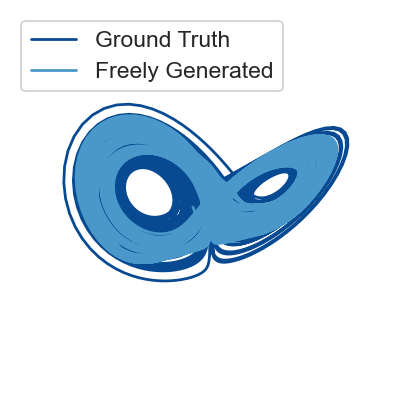

In [157]:
Blues = plt.cm.Blues
plt.rcParams["lines.linewidth"] = .35
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["lines.linewidth"] = 2.
plt.rcParams.update({'font.size': 10})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = orbit[:, 0]
ys = orbit[:, 1]
zs = orbit[:, 2]

ax.plot(X_test[:T_gen, 0], X_test[:T_gen, 1], X_test[:T_gen, 2], color=Blues (0.9), label="Ground Truth")
ax.plot(xs, ys, zs, color=Blues (0.6), alpha=1., label="Freely Generated")

plt.legend(loc="upper left")

plt.axis("off")
plt.show()

In [163]:
generated_latent=orbit[:,-P:] #latent sequence in PWL units
generated_observations=orbit[:,:N] #predicted readout sequence 

bits = lrf.convert_to_bits(generated_latent) #sequence of current active subregion, encoded in bits
regions, unique_regions = lrf.unique_regions_crossed(bits, M) #Number of linear subregions, used linear subregions encoded as bits
frequencies=lrf.frequency_of_regions(bits,unique_regions) #How often is each subregion visited

#Compute order of most freqnent visited subregions
frequency_list = np.copy(frequencies)
regions_list = np.copy(unique_regions)    
most_frequent_regions = []
for _ in range(len(frequency_list)):
    index = np.argmax(frequency_list)
    most_frequent_regions.append(regions_list[index])
    frequency_list = np.delete(frequency_list, index)
    regions_list = np.delete(regions_list, index, axis=0)

In [164]:
connectome = lrf.connectome_with_self_connections(bits, most_frequent_regions, len(most_frequent_regions))
print("Used subregions: ",len(connectome))
print("Timesteps in subregion: ",frequencies)

Used subregions:  3
Timesteps in subregion:  [3780 1872 4348]


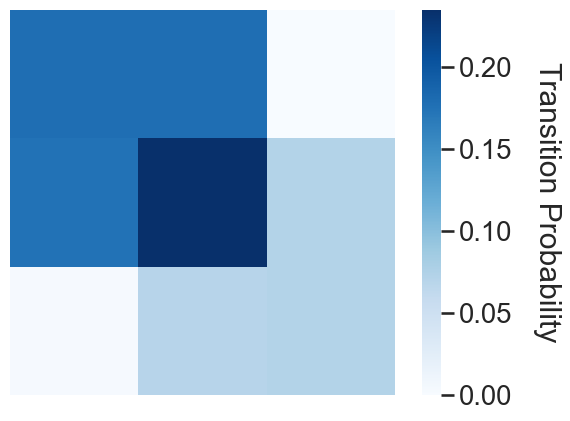

In [165]:
plt.figure(figsize=(7, 5))
sns.set_context('talk', font_scale=1.2) 
sns.set_style('white')

# Define a custom diverging colormap with higher contrast
#cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap = plt.get_cmap('Blues')

# Plot the heatmap with selected improvements
ax = sns.heatmap(data=connectome[:, :], annot=False, linewidths=0, cmap=cmap, square=True,
                 yticklabels=False, xticklabels=False, cbar_kws={'label': 'Transition Probability'})

# Rotate the colorbar label for better visibility
cbar = ax.collections[0].colorbar
cbar.set_label('Transition Probability', rotation=270, labelpad=35)

# Optionally, adjust the limits of the color map to enhance contrast
ax.collections[0].set_clim(0, np.max(connectome)-0.015)

plt.show()

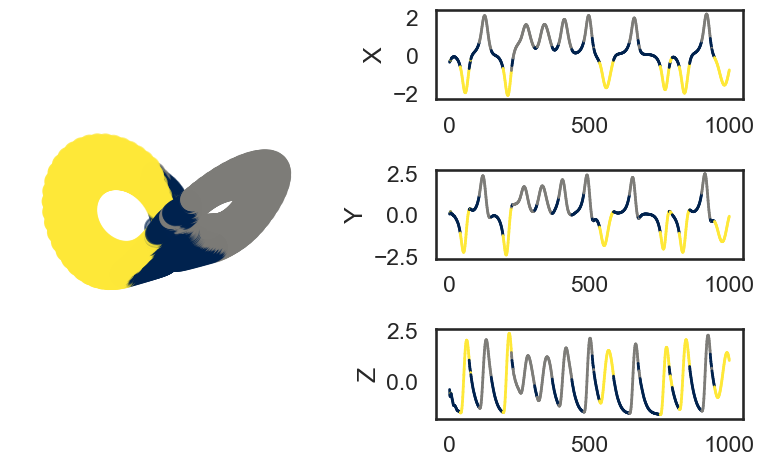

In [161]:
sns.set_context('talk', font_scale=1.0) 
plt.rcParams["lines.linewidth"] = 2.

observations_plot = generated_observations[:, :3]
bitcode_plot = lrf.convert_to_bits(generated_latent)

# Convert bitcode arrays to strings
bitcodes_str = [''.join(map(str, map(int, b))) for b in bitcode_plot]

# Count the frequency of each bitcode
bitcode_freq = Counter(bitcodes_str)
most_frequent_regions = [item[0] for item in bitcode_freq.most_common()]
frequency_order_map = {code: idx for idx, code in enumerate(most_frequent_regions)}
order = [frequency_order_map[code] for code in bitcodes_str]

# Normalize order indices for color mapping
order_array = np.array(order)
norm = Normalize(vmin=order_array.min(), vmax=order_array.max())
cmap = plt.get_cmap('cividis')
colors = cmap(norm(order_array))

fig = plt.figure(figsize=(8, 5))
#fig.tight_layout()
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(observations_plot[:, 0], observations_plot[:, 1], observations_plot[:, 2], c=colors, s=220)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis("off")

ax = fig.add_subplot(322)
for i in range(1000):
    ax.plot([i, i+1], [observations_plot[i, 0], observations_plot[i+1, 0]], color=colors[i+1])
ax.set_ylabel('X')

ax = fig.add_subplot(324)
for i in range(1000):
    ax.plot([i, i+1], [observations_plot[i, 1], observations_plot[i+1, 1]], color=colors[i+1])
ax.set_ylabel('Y')

ax = fig.add_subplot(326)
for i in range(1000):
    ax.plot([i, i+1], [observations_plot[i, 2], observations_plot[i+1, 2]], color=colors[i+1])
ax.set_ylabel('Z')

plt.tight_layout()
plt.show()